In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "TSLA", "BTC-USD", "META", "WMT", "XOM", "CDR.WA"]
df = yf.download(tickers, start="2015-01-01", end="2025-01-01")["Close"]

returns = np.log( df / df.shift(1)).dropna()
mu = returns.mean() * 252
cov_matrix = returns.cov() * 252



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed


In [4]:
def porfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = [(0, 1)] * (len(tickers))
initial_guess = [1 / len(tickers)] * (len(tickers))

In [5]:
results = minimize(porfolio_volatility, initial_guess, args=(cov_matrix), method="SLSQP", bounds=bounds, constraints=constraints)


optimal_weights = results.x

optimal_portfolio = dict(zip(tickers, optimal_weights))
print("Optimal Portfolio Weights:", optimal_portfolio)



Optimal Portfolio Weights: {'AAPL': 0.06047061834456486, 'MSFT': 0.031161995108300658, 'AMZN': 0.01508021904744173, 'GOOGL': 0.08636342685928354, 'TSLA': 0.07674525198378737, 'BTC-USD': 0.006464805158450644, 'META': 0.04027300443791355, 'WMT': 0.0022935306224781253, 'XOM': 0.44874817006032114, 'CDR.WA': 0.2323989783774583}


In [6]:
porfolio_volatility(optimal_weights, cov_matrix)

volatility = {}
sharpe_ratio = {}
for ticker in tickers:
    volatility[ticker] = returns[ticker].std() * np.sqrt(252)
    sharpe_ratio[ticker] = (mu[ticker]) - 0.02 / volatility[ticker]



In [10]:
num_of_portfolios = 5000
all_weights = np.zeros((num_of_portfolios, len(tickers)))
ret_arr = np.zeros(num_of_portfolios)
vol_arr = np.zeros(num_of_portfolios)
sharpe_arr = np.zeros(num_of_portfolios)

for i in range(num_of_portfolios):
    weights = np.array(np.random.random(len(tickers)))
    weights /= np.sum(weights)
    
    all_weights[i, :] = weights
    ret_arr[i] = np.dot(weights, mu)
    vol_arr[i] = porfolio_volatility(weights, cov_matrix)
    sharpe_arr[i] = ret_arr[i] - 0.02 / vol_arr[i]
    
simulations_data = [ret_arr, vol_arr, sharpe_arr, all_weights]
simulations_df = pd.DataFrame(data=simulations_data).T

simulations_df.columns = ["Returns", "Volatility", "Sharpe Ratio", "Portfolio Weights"]

simulations_df = simulations_df.infer_objects()
    
print('')
print('='*80)
print('SIMULATIONS RESULT:')
print('-'*80)
print(simulations_df.head())
print('-'*80)


SIMULATIONS RESULT:
--------------------------------------------------------------------------------
    Returns  Volatility  Sharpe Ratio  \
0  0.197159    0.218479      0.105617   
1  0.175947    0.202326      0.077097   
2  0.185096    0.216140      0.092563   
3  0.185855    0.212388      0.091688   
4  0.180024    0.215651      0.087282   

                                   Portfolio Weights  
0  [0.12191147472350691, 0.07315529096409872, 0.1...  
1  [0.04676396212751683, 0.12591171067156798, 0.0...  
2  [0.0076033482746362645, 0.20329347898068412, 0...  
3  [0.12849284833179286, 0.0443505544375543, 0.06...  
4  [0.18732353312405256, 0.09159261829700817, 0.1...  
--------------------------------------------------------------------------------


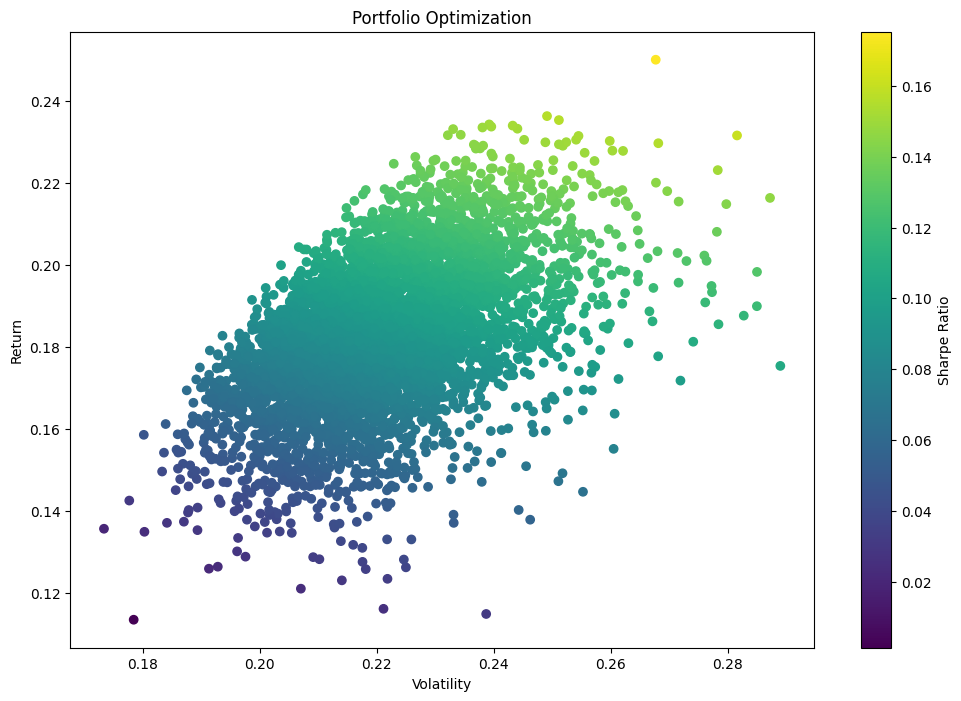

In [12]:
plt.figure(figsize=(12, 8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap="viridis", marker='o')
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Volatility")
plt.ylabel("Return")
plt.title("Portfolio Optimization")
plt.show()